In [1]:
import theano
import bokeh
import pymc3 as pm
import numpy as np
import theano.tensor as tt
from matplotlib import pyplot as plt

print('Running on PyMC3 v{}'.format(pm.__version__))

from datetime import datetime
import pickle # python3
import os
now = datetime.now

t_start = now()
print('hello')
print(t_start)

import multiprocessing
ncores = multiprocessing.cpu_count()
print('numcores: {}'.format(ncores))
#%%

Running on PyMC3 v3.8
hello
2020-02-21 12:42:52.175705
numcores: 28


In [2]:
m = [1,2,3];sd=[1,1,1];cov=np.eye(len(sd))*sd;
data1=pm.MvNormal.dist(mu=m,cov=cov).random(size=2000)

m = [7,8,9];sd=[1,1,1];cov=np.eye(len(sd))*sd;
data2=pm.MvNormal.dist(mu=m,cov=cov).random(size=1000)

#m = [15,16,17];sd=[1,1,1];cov=np.eye(len(sd))*sd;
#data3=pm.MvNormal.dist(mu=m,cov=cov).random(size=100)

data=np.vstack((data1,data2))

nsamples=data.shape[0]
ndim=data.shape[1]

print('Multivariate Data, 2 clusters, 123 ; 789,100 each')

Multivariate Data, 2 clusters, 123 ; 789,100 each


In [3]:
# Working model, inferring mus 

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

infinity=5
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    #beta = pm.Beta('beta', 1., alpha, shape=infinity)
    w = pm.Deterministic('w', stick_breaking(pm.Beta.dist(alpha=1,beta=alpha,shape=infinity).random()))
    w = w/tt.sum(w) # make sure it sums to 1, not .9999
    
    mus=[pm.Uniform('mu{}'.format(i),0,10,shape=ndim) for i in range(infinity)]
    components = [pm.MvNormal.dist(mu=mus[i], cov=np.eye(ndim), shape=data.shape) for i in range(infinity)]
    
    like = pm.Mixture('like', w=w, comp_dists = components, observed=data, shape=(infinity,data.shape[0],data.shape[1]))
    
print('model defined')

model defined


In [4]:
with model:
    approx = pm.fit(method='advi', callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')]);

trace = approx.sample(5000);
print(pm.summary(trace));

Average Loss = 25,848: 100%|██████████| 10000/10000 [00:56<00:00, 177.33it/s]
Finished [100%]: Average Loss = 25,809
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape v

         mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha   1.274  1.932   0.018    3.737      0.027    0.019    4947.0  4945.0   
w[0]    0.378  0.000   0.378    0.378      0.000    0.000    5000.0  5000.0   
w[1]    0.183  0.000   0.183    0.183      0.000    0.000    5000.0  5000.0   
w[2]    0.352  0.000   0.352    0.352      0.000    0.000    5000.0  5000.0   
w[3]    0.041  0.000   0.041    0.041      0.000    0.000    5000.0  5000.0   
w[4]    0.020  0.000   0.020    0.020      0.000    0.000    5000.0  5000.0   
mu0[0]  2.382  1.364   0.313    4.927      0.019    0.014    5026.0  4946.0   
mu0[1]  2.925  1.244   0.797    5.233      0.017    0.012    5090.0  5054.0   
mu0[2]  3.600  1.179   1.500    5.752      0.017    0.012    5063.0  5036.0   
mu1[0]  4.502  2.118   0.666    8.086      0.030    0.021    5055.0  4980.0   
mu1[1]  5.231  2.106   1.614    8.969      0.031    0.022    4661.0  4581.0   
mu1[2]  5.866  2.069   2.133    9.330      0.029    

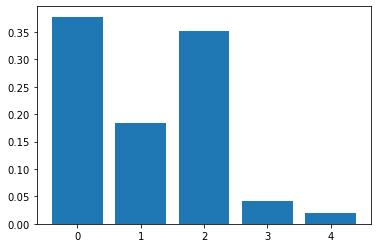

In [5]:
plt.bar(np.arange(infinity),trace['w'].mean(axis=0));

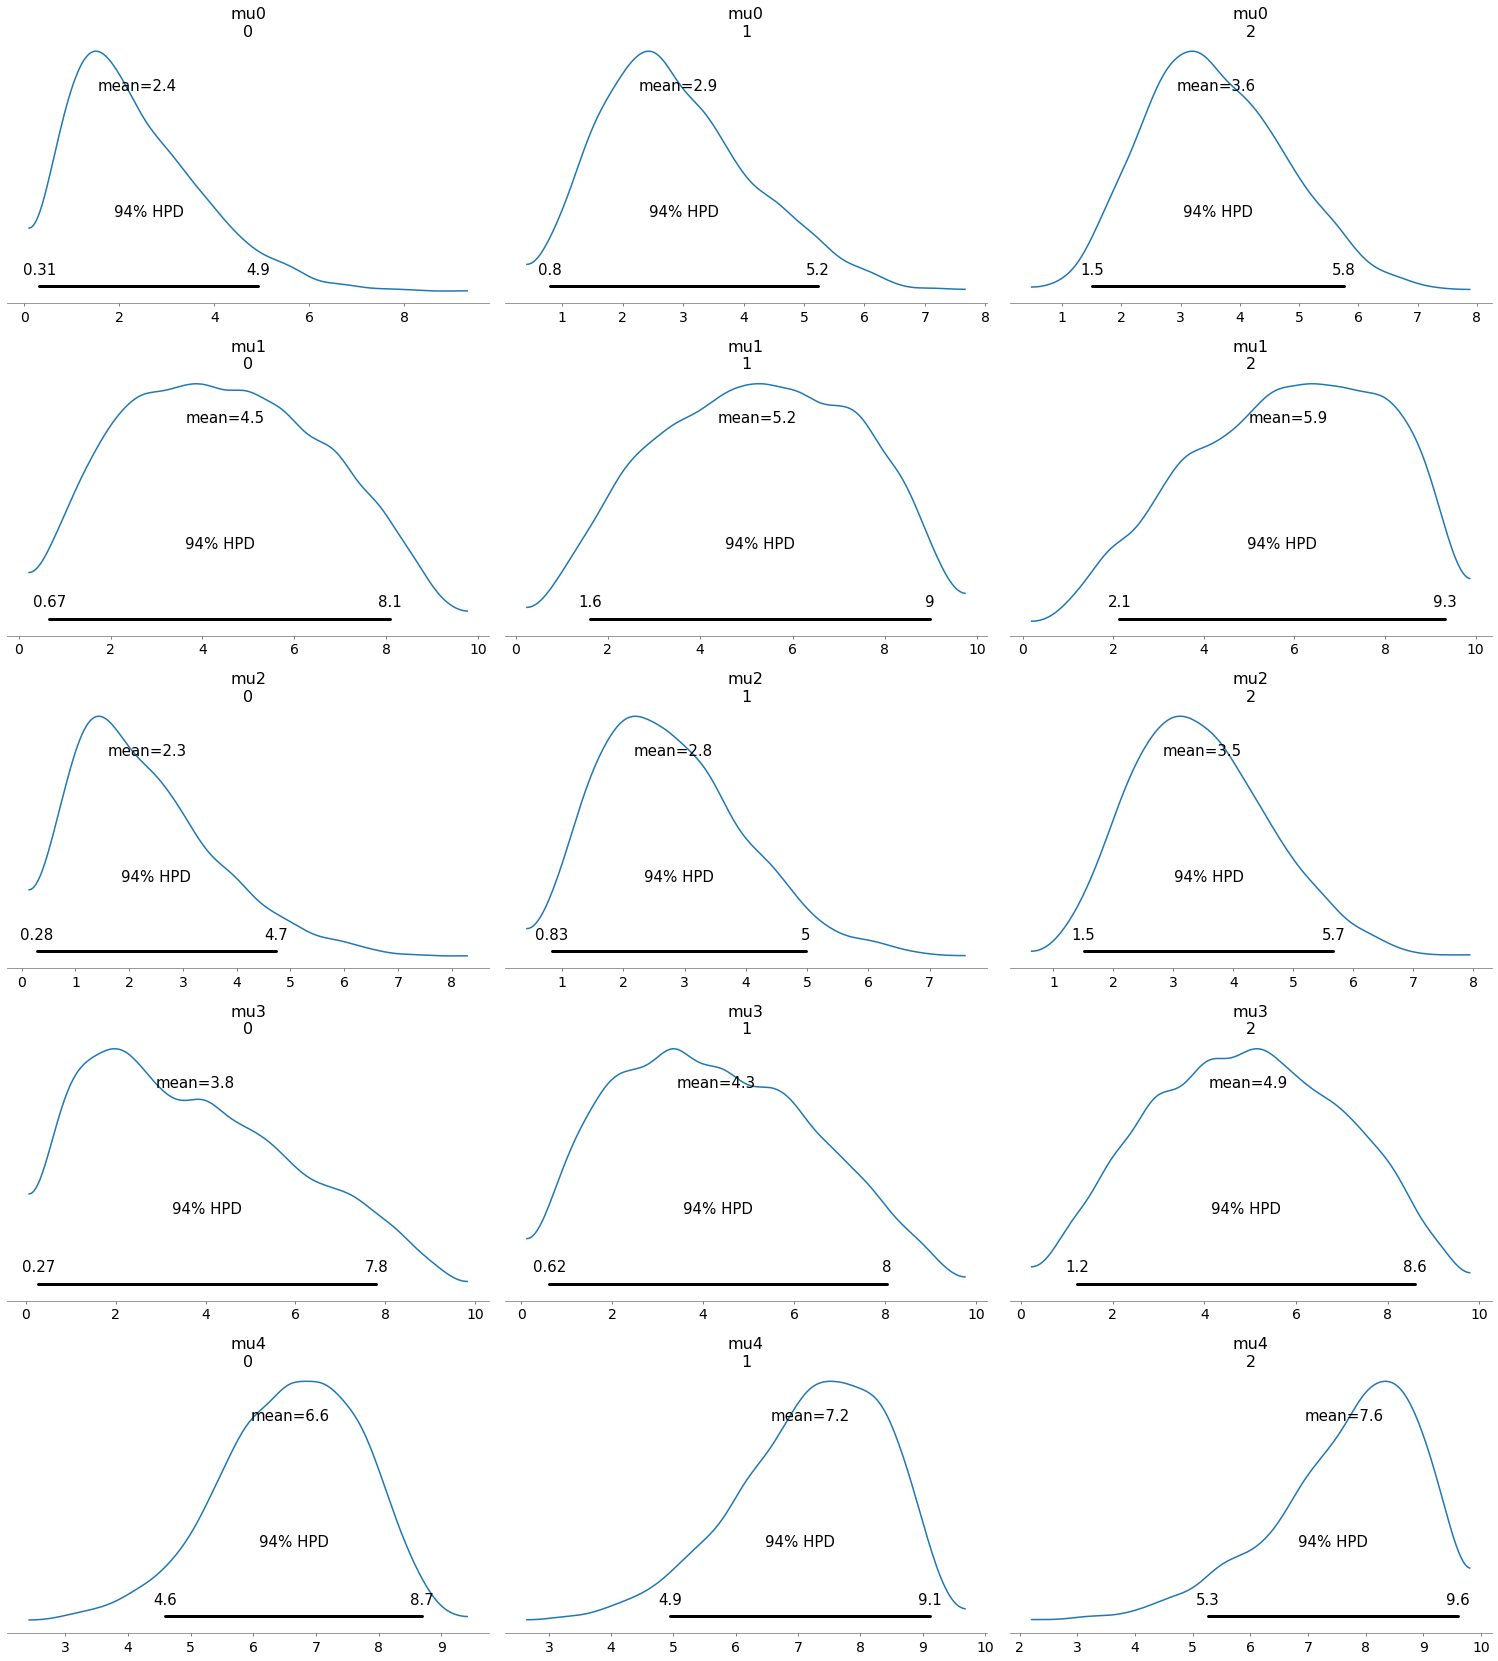

In [6]:
pm.plot_posterior(data=trace,var_names=['mu0','mu1','mu2','mu3','mu4']);
#pm.plot_posterior(data=trace,var_names=['mu1'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu2'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu3'],backend="matplotlib");
#pm.plot_posterior(data=trace,var_names=['mu4'],backend="matplotlib");

In [7]:
t_finish=now()

In [8]:
print('Time it took to run {}'.format(str(t_finish-t_start)))

Time it took to run 0:02:17.383592


In [9]:
#with model:
#    trace = pm.sample(draws=5000,cores=8,tune=500)    

In [10]:
#with model:
#    trace = pm.find_MAP()